In [1]:
# imports
import pathlib

import numpy as np
from PIL import Image

import torch
from transformers import AutoImageProcessor, AutoModel

from tqdm import tqdm

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import matplotlib.pyplot as plt

In [2]:
# paths and global configuration
BASE_PATH = pathlib.Path.cwd().resolve().parent.parent
DATA_PATH = BASE_PATH / "project" / "data"
REAL_PATH = DATA_PATH / "REAL"
FAKE_PATH = DATA_PATH / "FAKE"

# allowable image extensions
IMG_EXTS = {".jpg", ".jpeg", ".png"}

In [3]:
# data loading utility
def load_split(split_name: str):
    """
    Load image paths and labels for a given split (e.g., 'TRAIN' or 'TEST').

    The directory structure is assumed to be:
        DATA_PATH/
            REAL/<split_name>/
            FAKE/<split_name>/

    Args:
        split_name: Name of the split directory (e.g., 'TRAIN', 'TEST').

    Returns:
        paths: List of pathlib.Path objects for all images.
        labels: NumPy array of shape (N,) with integer labels:
            1 for REAL images, 0 for FAKE images.
    """
    real_dir = REAL_PATH / split_name
    fake_dir = FAKE_PATH / split_name

    # recursively collect all image files in REAL and FAKE subtrees
    real_paths = sorted(
        p
        for p in real_dir.rglob("*")
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    )

    fake_paths = sorted(
        p
        for p in fake_dir.rglob("*")
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    )

    # concatenate REAL and FAKE paths and build corresponding labels
    paths = real_paths + fake_paths
    labels = np.array(
        [1] * len(real_paths) + [0] * len(fake_paths),
        dtype=np.int64,
    )

    print(
        f"{split_name}: {len(real_paths)} real | "
        f"{len(fake_paths)} fake | total {len(paths)}"
    )

    return paths, labels

In [4]:
# load TRAIN and TEST splits
train_paths, y_train = load_split("TRAIN")
test_paths, y_test = load_split("TEST")

TRAIN: 8000 real | 8000 fake | total 16000
TEST: 2000 real | 2000 fake | total 4000


In [5]:
# feature extractor configuration (DINOv3 backbone)
MODEL_NAME = "facebook/dinov3-vits16-pretrain-lvd1689m"
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-11): 12 x DINOv3ViTLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (o_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=384, out_features=1536, bias=True)
        (down_proj): Linear(in_features=1536, out_features=384, bias=True)
        (act_fn): GELUActivation()
 

In [6]:
# embedding computation
def compute_embeddings(image_paths, batch_size: int = 16):
    """
    Compute pooled DINOv3 embeddings for a list of image paths.

    Args:
        image_paths: Sequence of pathlib.Path objects pointing to images.
        batch_size: Number of images to process per forward pass.

    Returns:
        embeds: NumPy array of shape (N, D) with one embedding per image.
    """
    embeds = []

    # number of mini-batches for iteration
    num_batches = (len(image_paths) + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches), desc="Embedding images"):
        start = i * batch_size
        batch_paths = image_paths[start : start + batch_size]

        images = []

        # load each image in the batch, converting to RGB
        for p in batch_paths:
            try:
                img = Image.open(p).convert("RGB")
                images.append(img)
            except Exception as e:
                # Any failed image loads are reported and skipped
                print(f"Warning: failed to load {p}: {e}")

        # if all images in this batch fail to load, simply continue
        if not images:
            continue

        # preprocess batch of images for the model
        inputs = processor(images=images, return_tensors="pt").to(device)

        # forward pass without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)

            # use the pooled output as the embedding representation
            batch_embs = outputs.pooler_output

        # move embeddings to CPU and convert to NumPy
        embeds.append(batch_embs.cpu().numpy())

    # stack all batches vertically into a single (N, D) array
    return np.vstack(embeds)

In [7]:
# compute TRAIN and TEST embeddings
X_train = compute_embeddings(train_paths, batch_size=32)
X_test = compute_embeddings(test_paths, batch_size=32)

print("Train features:", X_train.shape)
print("Test features:", X_test.shape)

Embedding images: 100%|██████████| 125/125 [00:30<00:00,  4.07it/s]

Train features: (16000, 384)
Test features: (4000, 384)


In [8]:
# SVM classifier: pipeline and hyperparameter search
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svc", SVC()),
    ]
)

# hyperparameter grid for SVM search (RBF kernel only)
param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],
    "svc__class_weight": [None, "balanced"],
}

# stratified K-fold preserves label distribution in splits
cv = StratifiedKFold(
    n_splits=4,
    shuffle=True,
    random_state=404,
)

# grid search over the SVM hyperparameters using macro F1
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,  # use all available cores
    verbose=1,
)

# fit grid search on training embeddings
grid.fit(X_train, y_train)

print("Best parameters found:")
print(grid.best_params_)
print()

print("Best cross-validated f1_macro:")
print(grid.best_score_)
print()

# retrieve the best-performing model from the grid search
best_model = grid.best_estimator_

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters found:
{'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Best cross-validated f1_macro:
0.9180613379747726



Test accuracy: 0.91425

              precision    recall  f1-score   support

    FAKE (0)       0.92      0.91      0.91      2000
    REAL (1)       0.91      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

Confusion matrix (counts):
[[1817  183]
 [ 160 1840]]

Confusion matrix (normalized):
[[0.9085 0.0915]
 [0.08   0.92  ]]


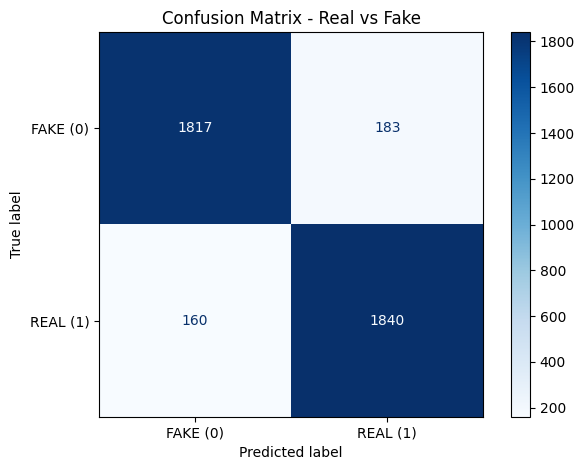

In [9]:
# evaluation on the TEST split
y_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print()
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["FAKE (0)", "REAL (1)"],
    )
)

# confusion matrix in raw counts
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (counts):")
print(cm)

# normalized confusion matrix (per true label)
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
print("\nConfusion matrix (normalized):")
print(cm_norm)

# plot confusion matrix for TEST split
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["FAKE (0)", "REAL (1)"],
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Real vs Fake")
plt.tight_layout()
plt.show()

BENCHMARK: 50000 real | 50000 fake | total 100000


Embedding images: 100%|██████████| 6250/6250 [10:23<00:00, 10.03it/s]


Benchmark features: (100000, 384)
Benchmark accuracy: 0.9507

              precision    recall  f1-score   support

    FAKE (0)       0.95      0.96      0.95     50000
    REAL (1)       0.95      0.95      0.95     50000

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000

Benchmark confusion matrix (counts):
[[47768  2232]
 [ 2698 47302]]

Benchmark confusion matrix (normalized):
[[0.95536 0.04464]
 [0.05396 0.94604]]


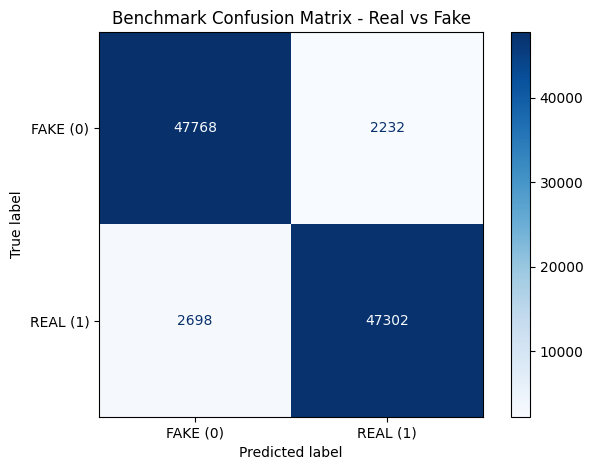

In [10]:
# benchmark split loading and evaluation
BENCHMARK_PATH = DATA_PATH / "benchmark"

def load_benchmark_dataset():
    """
    Load REAL and FAKE images from the BENCHMARK split.

    Directory structure is assumed to be:
        BENCHMARK_PATH/
            REAL/
            FAKE/

    Returns:
        paths: List of pathlib.Path objects for all benchmark images.
        labels: NumPy array of shape (N,) with labels:
            1 for REAL images, 0 for FAKE images.
    """
    real_dir = BENCHMARK_PATH / "REAL"
    fake_dir = BENCHMARK_PATH / "FAKE"

    real_paths = sorted(
        p
        for p in real_dir.rglob("*")
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    )

    fake_paths = sorted(
        p
        for p in fake_dir.rglob("*")
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    )

    paths = real_paths + fake_paths
    labels = np.array(
        [1] * len(real_paths) + [0] * len(fake_paths),
        dtype=np.int64,
    )

    print(
        f"BENCHMARK: {len(real_paths)} real | "
        f"{len(fake_paths)} fake | total {len(paths)}"
    )

    return paths, labels


# load benchmark dataset
bench_paths, y_bench = load_benchmark_dataset()

# compute benchmark embeddings
X_bench = compute_embeddings(bench_paths, batch_size=16)
print("Benchmark features:", X_bench.shape)

# evaluate best model on benchmark data
y_bench_pred = best_model.predict(X_bench)

print("Benchmark accuracy:", accuracy_score(y_bench, y_bench_pred))
print()
print(
    classification_report(
        y_bench,
        y_bench_pred,
        target_names=["FAKE (0)", "REAL (1)"],
    )
)

# confusion matrix (counts) for benchmark
cm_bench = confusion_matrix(y_bench, y_bench_pred)
print("Benchmark confusion matrix (counts):")
print(cm_bench)

# normalized confusion matrix for benchmark
cm_bench_norm = confusion_matrix(y_bench, y_bench_pred, normalize="true")
print("\nBenchmark confusion matrix (normalized):")
print(cm_bench_norm)

# plot confusion matrix for benchmark split
disp_bench = ConfusionMatrixDisplay(
    confusion_matrix=cm_bench,
    display_labels=["FAKE (0)", "REAL (1)"],
)
disp_bench.plot(cmap="Blues")
plt.title("Benchmark Confusion Matrix - Real vs Fake")
plt.tight_layout()
plt.show()